🧪 正在生成模拟图灵斑图...
✅ 数据准备完毕: (10000, 2)
初始化猎人 (PyTorch版):
  - 物理范围: X[0.0, 100.0], Y[0.0, 100.0]
  - Bin Size: 1 (微米/像素)
  - 生成图像尺寸: 100 x 100 像素
  - 计算设备: cuda
>>> L1: 正在扫描 2 个基因 (GPU加速)...
    已处理 2/2...
筛选完成。

>>> 🏆 扫描结果 (Top Candidates):
          gene  peak_score
0  Gene_Turing    0.502518
1  Gene_Random    0.182467

📸 图片已保存为 turing_demo.png！请查看你的目录。


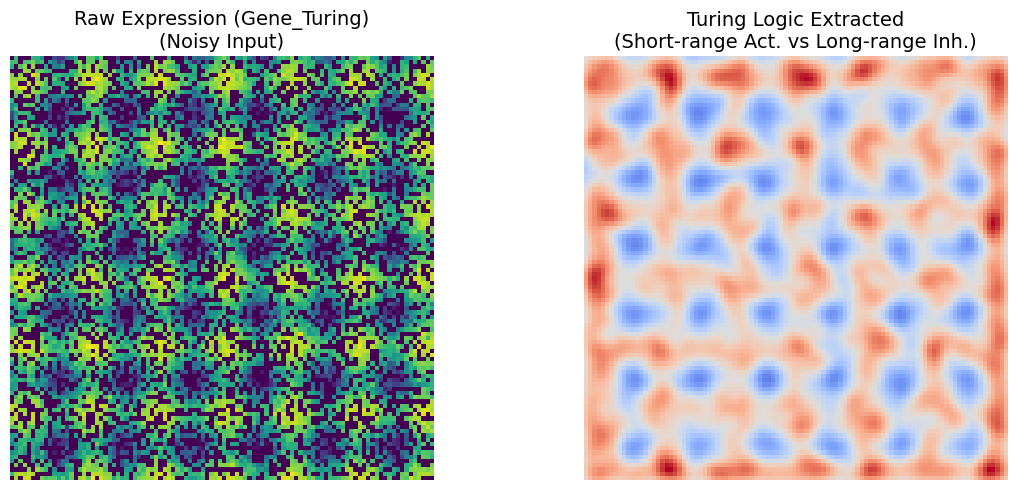

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from spatialturing import TuringPatternHunter

# ==========================================
# 1. 造一个“虚拟胚胎” (Synthetic Data)
# ==========================================
print("🧪 正在生成模拟图灵斑图...")
n_cells = 10000
w, h = 100, 100
# 随机生成坐标
coords = np.random.rand(n_cells, 2) * [w, h]

# 制造一个类似于斑马纹的图灵模式 (Activator)
x, y = coords[:, 0], coords[:, 1]
# 频率为 0.5 的正弦波条纹 + 混合余弦
true_pattern = np.sin(x * 0.4) + np.cos(y * 0.4)
# 归一化到 0-5 之间作为表达量
expr_activator = (true_pattern - true_pattern.min())
expr_activator = expr_activator / expr_activator.max() * 5
# 加入一些噪声 (模拟真实测序数据的 dropout 和 noise)
expr_activator += np.random.normal(0, 0.5, n_cells)
expr_activator[expr_activator < 0] = 0

# 制造一个完全随机的噪音基因 (Noise)
expr_noise = np.random.exponential(1, n_cells)

# 封装进 AnnData
adata = sc.AnnData(X=np.stack([expr_activator, expr_noise], axis=1))
adata.var_names = ['Gene_Turing', 'Gene_Random'] 
adata.obsm['spatial'] = coords

print(f"✅ 数据准备完毕: {adata.shape}")

# ==========================================
# 2. 启动 SpatialTuring 猎人
# ==========================================
# 初始化 (自动检测 GPU)
hunter = TuringPatternHunter(adata, bin_size=1) 

# Step 1: 扫描 (使用 DoG 滤波)
# 我们预期 Gene_Turing 会得分很高，Gene_Random 会很低
candidates_u, candidates_v = hunter.screen_geometry(sigma_inner=2, sigma_outer=5, top_n=10)

print("\n>>> 🏆 扫描结果 (Top Candidates):")
print(candidates_u[['gene', 'peak_score']])

# ==========================================
# 3. 可视化 (生成 README 图片)
# ==========================================
gene = 'Gene_Turing'

# 手动获取 tensor 图片用于绘图
raw_img = hunter._get_gene_image_tensor([gene]).cpu().numpy().squeeze()

# 手动做一次 DoG 方便展示提取后的信号
tensor_img = torch.tensor(raw_img).unsqueeze(0).unsqueeze(0).to(hunter.device)
k_in, _ = hunter._create_gaussian_kernel(2)
k_out, _ = hunter._create_gaussian_kernel(5)
# 使用 padding 保持尺寸
pad_in = k_in.shape[-1] // 2
pad_out = k_out.shape[-1] // 2
dog_img = (torch.nn.functional.conv2d(tensor_img, k_in, padding=pad_in) - 
           torch.nn.functional.conv2d(tensor_img, k_out, padding=pad_out)).cpu().numpy().squeeze()

# 绘图：一张高大上的对比图
plt.figure(figsize=(12, 5))

# 左图：原始数据 (Raw)
plt.subplot(1, 2, 1)
plt.imshow(raw_img, cmap='viridis', origin='lower')
plt.title(f"Raw Expression ({gene})\n(Noisy Input)", fontsize=14)
plt.axis('off')

# 右图：图灵逻辑提取 (DoG)
plt.subplot(1, 2, 2)
# 使用 coolwarm 这种红蓝对比色，突出激活(红)-抑制(蓝)
vmax = np.abs(dog_img).max()
plt.imshow(dog_img, cmap='coolwarm', origin='lower', vmin=-vmax, vmax=vmax)
plt.title(f"Turing Logic Extracted\n(Short-range Act. vs Long-range Inh.)", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.savefig("turing_demo.png", dpi=300) # 保存图片
print("\n📸 图片已保存为 turing_demo.png！请查看你的目录。")
plt.show()